# Interior Point Method

In this demo, we briefly compare the performance between interior point method and the proximal gradient method.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Create the Problem

Consider minimize a quadratic problem over box constraint,
$$
\min_x~~\frac{1}{2}\|Ax - b\|^2, \quad\text{s.t.}~~ l \le x \le u.
$$

In [2]:
np.random.seed(777)
m = 10
n = 2
k = 50.0
l = np.repeat(1.0, n)
u = np.repeat(2.0, n)
#
A = np.random.randn(m, n)
U,S,V = np.linalg.svd(A, full_matrices=False)
S[0] = k
S[1] = 1.0
A = U @ np.diag(S) @ V
#
x_true = np.array([0.75, 1.5])
b = A.dot(x_true)

In [3]:
N = 501
x1 = np.linspace(0.5, 2.5, N)
x2 = np.linspace(0.5, 2.5, N)
x1, x2 = np.meshgrid(x1, x2)
x_grid = np.dstack((x1, x2))

In [4]:
X = x_grid.transpose(2,0,1).reshape(2, N*N)
v = np.sum((A.dot(X) - b.reshape(m, 1))**2, 0).reshape(N, N) 

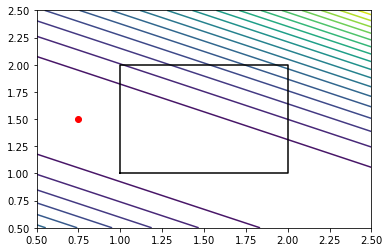

In [5]:
# plot contour
plt.contour(x1, x2, v, levels=20)
# plot true x
plt.plot(x_true[0], x_true[1], 'or')
# plot the box
plt.plot([l[0], l[0], u[0], u[0], l[0]], [l[1], u[1], u[1], l[1], l[1]], '-k')

## Proximal Gradient Descent

In [6]:
f = lambda x: 0.5*np.sum((A.dot(x) - b)**2)
g = lambda x: A.T.dot(A.dot(x) - b)
L = np.linalg.norm(A,2)**2
s = 1.0/L
def prox(x):
    return np.minimum(np.maximum(x, l), u)

In [7]:
def pgd(x0, tol=1e-6, max_iter=10000):
    x_history = np.zeros((max_iter + 1, 2))
    x_history[0] = x0
    fx = f(x0)
    gx = g(x0)
    #
    err = 1.0
    for i in range(1, max_iter+1):
        x_history[i] = prox(x_history[i-1] - s*gx)
        #
        fx = f(x_history[i])
        gx = g(x_history[i])
        #
        err = np.linalg.norm(x_history[i] - x_history[i-1])/s
        #
        print('iter %3d, obj %7.2e, err %7.2e' % (i, fx, err))
        #
        if err < tol:
            break
    #
    return x_history[:i]

In [8]:
x0 = 0.5*(l + u)
x_pgd = pgd(x0)

iter   1, obj 2.23e-01, err 8.51e+02
iter   2, obj 2.23e-01, err 6.68e-01
iter   3, obj 2.23e-01, err 6.68e-01
iter   4, obj 2.23e-01, err 6.68e-01
iter   5, obj 2.22e-01, err 6.67e-01
iter   6, obj 2.22e-01, err 6.67e-01
iter   7, obj 2.22e-01, err 6.67e-01
iter   8, obj 2.22e-01, err 6.67e-01
iter   9, obj 2.22e-01, err 6.66e-01
iter  10, obj 2.22e-01, err 6.66e-01
iter  11, obj 2.21e-01, err 6.66e-01
iter  12, obj 2.21e-01, err 6.65e-01
iter  13, obj 2.21e-01, err 6.65e-01
iter  14, obj 2.21e-01, err 6.65e-01
iter  15, obj 2.21e-01, err 6.65e-01
iter  16, obj 2.21e-01, err 6.64e-01
iter  17, obj 2.20e-01, err 6.64e-01
iter  18, obj 2.20e-01, err 6.64e-01
iter  19, obj 2.20e-01, err 6.64e-01
iter  20, obj 2.20e-01, err 6.63e-01
iter  21, obj 2.20e-01, err 6.63e-01
iter  22, obj 2.19e-01, err 6.63e-01
iter  23, obj 2.19e-01, err 6.63e-01
iter  24, obj 2.19e-01, err 6.62e-01
iter  25, obj 2.19e-01, err 6.62e-01
iter  26, obj 2.19e-01, err 6.62e-01
iter  27, obj 2.19e-01, err 6.61e-01
i

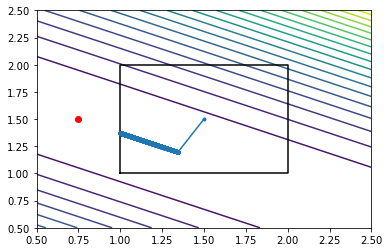

In [10]:
# plot contour
plt.contour(x1, x2, v, levels=20)
# plot true x
plt.plot(x_true[0], x_true[1], 'or')
# plot the box
plt.plot([l[0], l[0], u[0], u[0], l[0]], [l[1], u[1], u[1], l[1], l[1]], '-k')
# plot convergence path of proximal gradient descent
plt.plot(x_pgd[:,0], x_pgd[:,1], '.-')

# Interior Point Method

In [11]:
I = np.eye(n)
C = np.vstack((I, -I))
c = np.hstack((u, -l))
ATA = A.T.dot(A)
ATb = A.T.dot(b)

In [12]:
def IP(x0, mu=1.0, ratio=0.1, tol=1e-6, max_iter=20):  
    x_history = np.zeros((max_iter + 1, 2))
    x_history[0] = x0
    r = A.dot(x0) - b
    d = c - C.dot(x0)
    q = mu/d
    z = np.hstack((x0, q))
    #
    id_x = slice(n)
    id_q = slice(n, 3*n)
    #
    dF = np.zeros((3*n, 3*n))
    dF[id_x, id_x] = ATA
    dF[id_x, id_q] = C.T
    dF[id_q, id_x] = -np.diag(q).dot(C)
    dF[id_q, id_q] = np.diag(d)
    #
    F = np.zeros(3*n)
    F[id_x] = A.T.dot(r) + C.T.dot(q)
    F[id_q] = q*d - mu
    #
    for i in range(1, max_iter+1):
        dz = -np.linalg.solve(dF, F)
        # safe guard on stepsize
        s = 1.0
        dx = dz[id_x]
        dq = dz[id_q]
        Cdx = C.dot(dx)
        valid_x = np.where(Cdx > 0)[0]
        valid_q = np.where(dq < 0)[0]
        s = min(s, np.min(d[valid_x]/Cdx[valid_x]))
        s = min(s, np.min(-q[valid_q]/dq[valid_q]))
        # update variable
        z = z + s*dz
        x = z[id_x]
        q = z[id_q]
        d = c - C.dot(x)
        r = A.dot(x) - b
        x_history[i] = x
        # update mu
        mu = ratio*np.mean(q*d)
        # update dF and F
        dF[id_q, id_x] = -np.diag(q).dot(C)
        dF[id_q, id_q] = np.diag(d)
        #
        F[id_x] = A.T.dot(r) + C.T.dot(q)
        F[id_q] = q*d - mu
        #
        err = np.linalg.norm(F)
        #
        print('iter %3d, err %7.2e, s %7.2e, mu %7.2e' % (i, err, s, mu))
        #
        if err < tol:
            break
    #
    return x_history[:i]

In [13]:
x0 = 0.5*(l + u) 
x_ip = IP(x0)

iter   1, err 1.37e+00, s 1.00e+00, mu 7.59e-02
iter   2, err 1.75e-01, s 1.00e+00, mu 7.69e-03
iter   3, err 4.18e-02, s 1.00e+00, mu 1.45e-03
iter   4, err 7.65e-03, s 1.00e+00, mu 3.17e-04
iter   5, err 9.01e-04, s 1.00e+00, mu 4.35e-05
iter   6, err 8.20e-05, s 1.00e+00, mu 4.54e-06
iter   7, err 8.18e-06, s 1.00e+00, mu 4.54e-07
iter   8, err 8.18e-07, s 1.00e+00, mu 4.54e-08


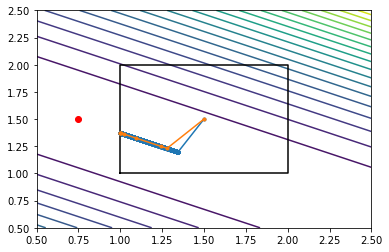

In [14]:
# plot contour
plt.contour(x1, x2, v, levels=20)
# plot true x
plt.plot(x_true[0], x_true[1], 'or')
# plot the box
plt.plot([l[0], l[0], u[0], u[0], l[0]], [l[1], u[1], u[1], l[1], l[1]], '-k')
# plot convergence path of proximal gradient descent
plt.plot(x_pgd[:,0], x_pgd[:,1], '.-')
# plot convergence path of interior point method
plt.plot(x_ip[:,0], x_ip[:,1], '.-')